## Homework 06: due 2024/06/10 23:59(100%)

### - There are differences between every OpenCV version, please make sure the opencv version is above 4.4 to avoid the bugs.  

### - Tutorial : 
1. Panorama tutorial : https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/
2. cv2.Sticher document: https://docs.opencv.org/4.4.0/d2/d8d/classcv_1_1Stitcher.html
3. cv2.Sticher tutorial: https://docs.opencv.org/4.4.0/d5/d48/samples_2python_2stitching_8py-example.html

                   
### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import argparse
from matplotlib.gridspec import GridSpec

### 1. Feature Matching (30%)
#### Please use __SIFT__ as detector and descriptor to find the correponding feature points in __./Data/01.jpg__ and __./Data/02.jpg__. Also, please apply Lowe's ratio test with appropriate ratio and draw the matching feature points as the figure below.
##### (example figure)
![Imgur](https://imgur.com/uv6qrHc.jpg)

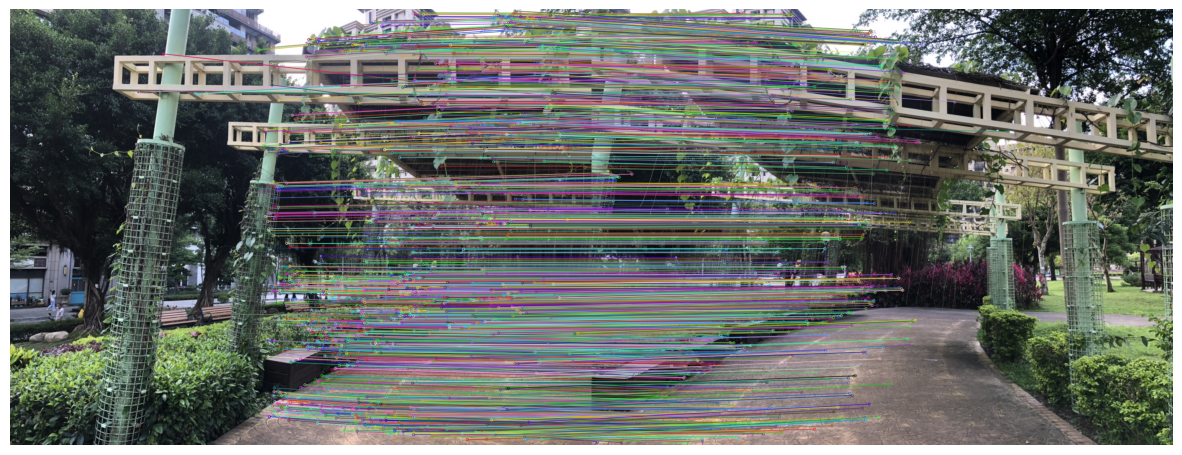

In [2]:
img1 = cv2.imread('data/01.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('data/02.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good1 = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good1.append([m])
        
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good1, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(1, 1, figsize=(15,10))
axs.imshow(img3)
axs.axis('off')
plt.show()

### 2. Homography and stitching. (40%)
#### 2.1 Please calculate the homography matrix with the point correspondences that detect from the first part. Also, warp the images and stitch image 01.jpg and 02.jpg together. (cv2.Sticher is not allowed in this part) (20%)
##### (Example figure)
![Imgur](https://imgur.com/U2epbTY.jpg)

In [3]:
def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    # When we have established a homography we need to warp perspective
     # Change field of view
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
    translation_dist = [-x_min,-y_min]
  
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

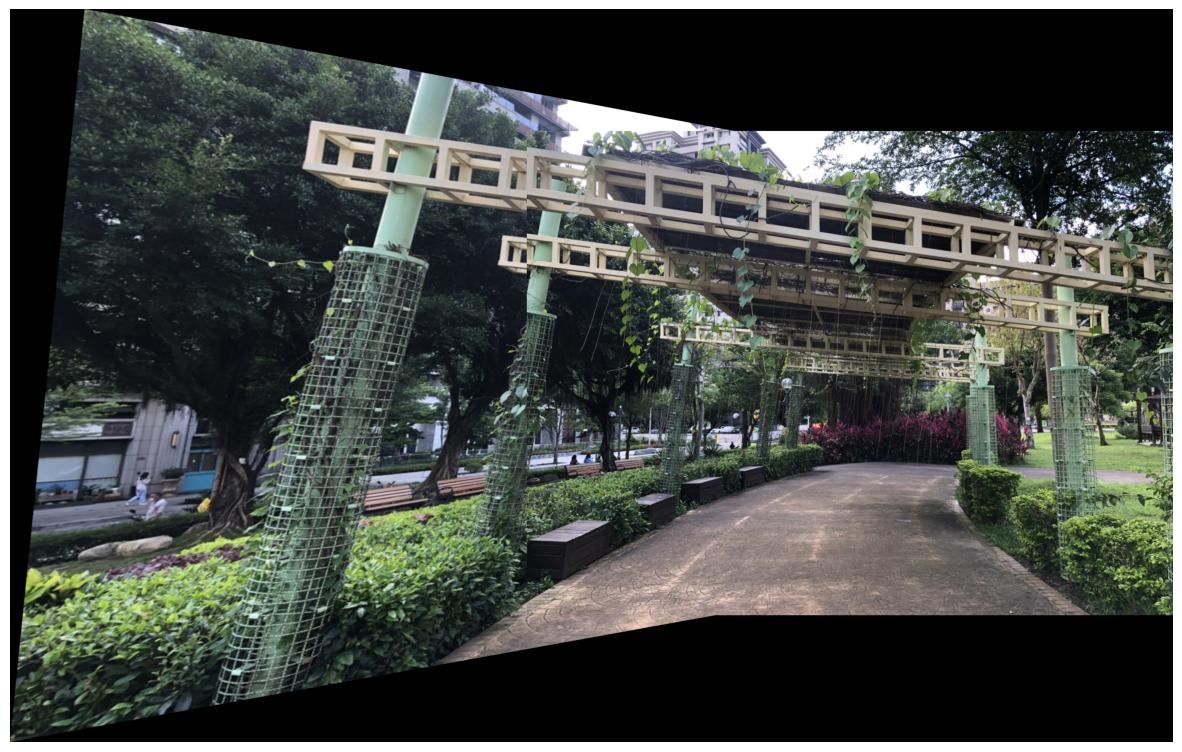

In [4]:
MIN_MATCH_COUNT = 10

if len(good1) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([kp1[good1[i][0].queryIdx].pt for i in range(len(good1))]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[good1[i][0].trainIdx].pt for i in range(len(good1))]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)
    
fig, axs = plt.subplots(1, 1, figsize=(15,10))
axs.imshow(result)
axs.axis('off')
plt.show()

#### 2.2 Please read the tutorials and the documentations of __cv2.Stitcher__ to stitch all the seven images. (20%) 
![Imgur](https://imgur.com/drUvu38.jpg)

Stitching completed successfully


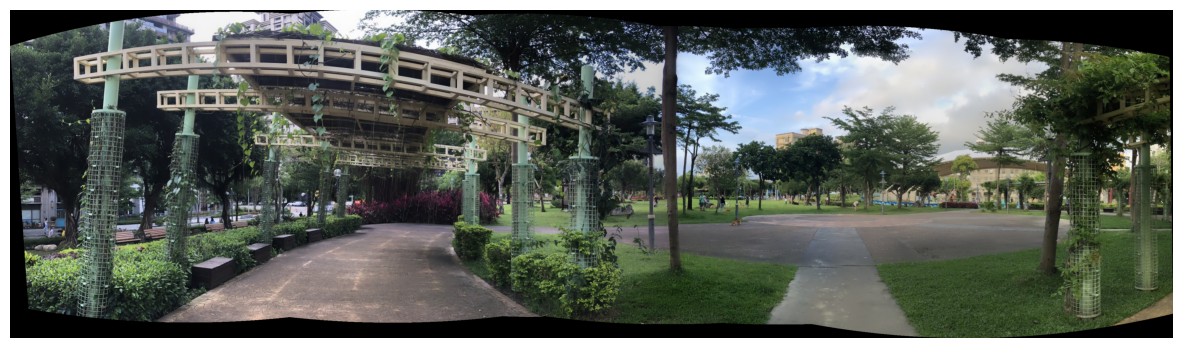

In [5]:
filename = os.listdir('data')
imgs = []
for i in filename:
    img = cv2.imread('data/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)

stitcher = cv2.Stitcher.create(mode=cv2.Stitcher_PANORAMA)
status, result = stitcher.stitch(imgs)

if status != cv2.Stitcher_OK:
    print("Can't stitch images, error code = %d" % status)
else:
    print("Stitching completed successfully")

fig, axs = plt.subplots(1, 1, figsize=(15,10))
axs.imshow(result)
axs.axis('off')
plt.show()

### 3. Build your own panorama. (30%)

Please take some pictures on your own and follow the steps above to build your own panorama, and write down your observation.

Stitching completed successfully


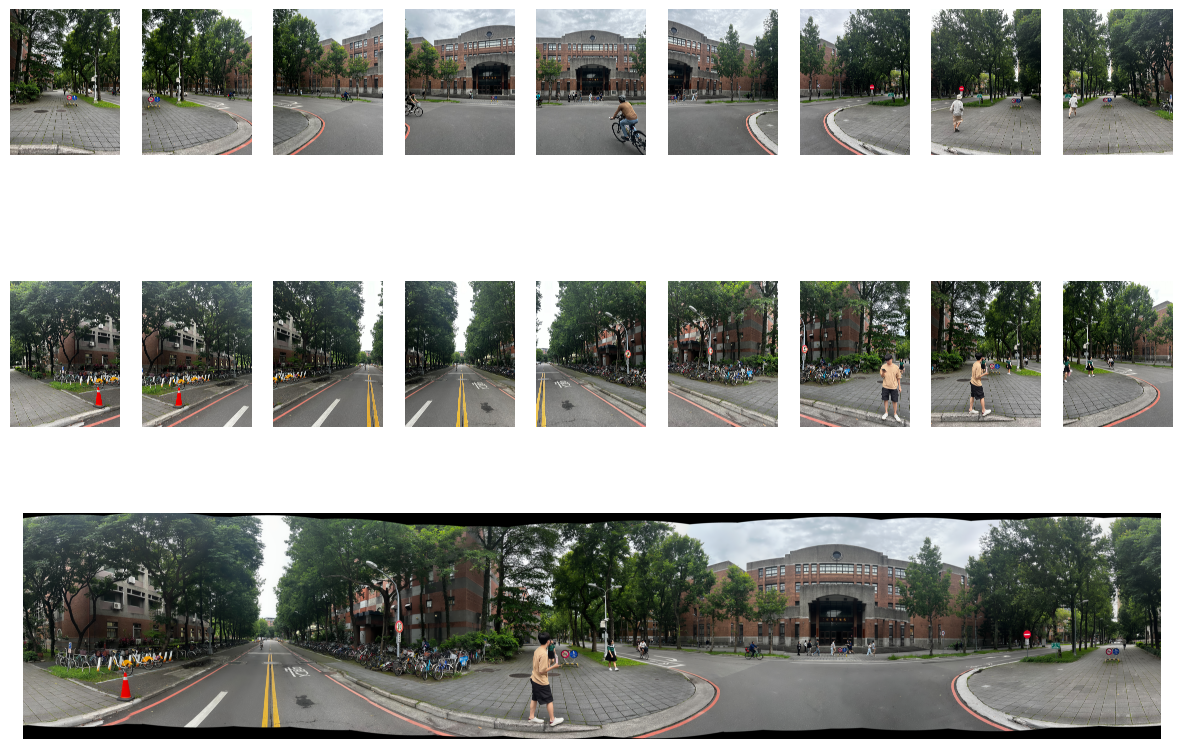

In [6]:
filename = os.listdir('data2')
imgs = []
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 9, figure=fig)

for i, x in enumerate(filename):
    img = cv2.imread('data2/' + x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(gs[i//9, i%9])
    ax.imshow(img)
    ax.axis('off')
    imgs.append(img)

stitcher = cv2.Stitcher.create(mode=cv2.Stitcher_PANORAMA)
status, result = stitcher.stitch(imgs)

if status != cv2.Stitcher_OK:
    print("Can't stitch images, error code = %d" % status)
else:
    print("Stitching completed successfully")

ax = fig.add_subplot(gs[2, :])
ax.imshow(result)
ax.axis('off')
plt.show()

Stitching completed successfully


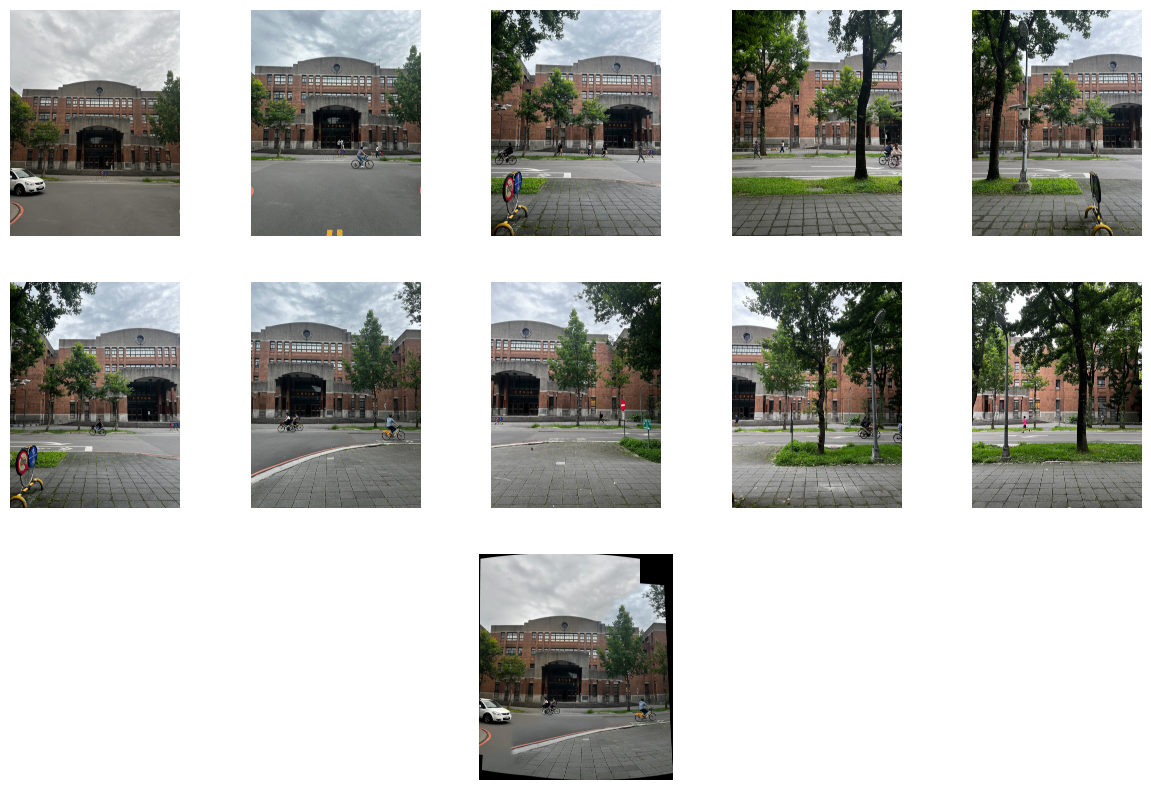

In [7]:
filename = os.listdir('data1')
imgs = []
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 5, figure=fig)

for i, x in enumerate(filename):
    img = cv2.imread('data1/' + x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(gs[i//5, i%5])
    ax.imshow(img)
    ax.axis('off')
    imgs.append(img)

stitcher = cv2.Stitcher.create(mode=cv2.Stitcher_PANORAMA)
status, result = stitcher.stitch(imgs)

if status != cv2.Stitcher_OK:
    print("Can't stitch images, error code = %d" % status)
else:
    print("Stitching completed successfully")

ax = fig.add_subplot(gs[2, :])
ax.imshow(result)
ax.axis('off')
plt.show()

#### Answer:
When stitching images, it is best for photographers to stand at the same fixed point. Small-scale horizontal movement or not taking photos far enough away may result in images that cannot be stitched together and become severely distorted.